In [1]:
import os
import pandas as pd
root = './data/celeba'
attributes = pd.read_csv(os.path.join(root, 'list_attr_celeba.csv'))
images_dir = os.path.join(root, 'img_align_celeba')

In [2]:
from src.models.autoencoder import AutoEncoder

In [3]:
good_attribute_threshold = 0.3
good_attributes = ['image_id']
for key in attributes.keys():
    c = attributes[attributes[key]==1]['image_id'].count()
    if c < len(attributes)*(1-good_attribute_threshold) and c > len(attributes) * good_attribute_threshold:
        good_attributes.append(key)
gdf = attributes[good_attributes]

In [4]:
from collections import Counter
import math
import scipy.stats as ss
import numpy as np
_REPLACE = 'replace'
_DROP = 'drop'
_DROP_SAMPLES = 'drop_samples'
_DROP_FEATURES = 'drop_features'
_SKIP = 'skip'
_DEFAULT_REPLACE_VALUE = 0.0
def conditional_entropy(x,
                        y,
                        log_base: float = math.e):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy
def theils_u(x,
             y,
             nan_strategy=_REPLACE,
             nan_replace_value=_DEFAULT_REPLACE_VALUE):

    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1.
    else:
        return (s_x - s_xy) / s_x

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
face_attr = ['Male','Mouth_Slightly_Open','Smiling','Wearing_Lipstick','Eyeglasses','Young','Chubby','Blond_Hair','Attractive','No_Beard','Mustache']
s = []
for attr in face_attr:
    s.append(attributes[attr].squeeze().replace(1,0).replace(-1, 1))

cramer_mat = pd.DataFrame(np.zeros((len(face_attr), len(face_attr))))
theils_mat = pd.DataFrame(np.zeros((len(face_attr), len(face_attr))))
for i in range(len(face_attr)):
    for j in range(len(face_attr)):
        cramer_mat[i][j] = cramers_v(s[i],s[j])
        theils_mat[i][j] = theils_u(s[i],s[j])



In [6]:
rename = dict(zip(range(len(face_attr)), face_attr))
cramer_mat.rename(columns=rename, index=rename)
theils_mat.rename(columns=rename, index=rename)

,Male,Mouth_Slightly_Open,Smiling,Wearing_Lipstick,Eyeglasses,Young,Chubby,Blond_Hair,Attractive,No_Beard,Mustache
Male,1.000000,0.007181,0.013889,0.561928,0.086071,0.075050,0.127235,0.134777,0.115507,0.364186,0.216937
Mouth_Slightly_Open,0.007322,1.000000,0.218927,0.007886,0.000081,0.000190,0.001478,0.005868,0.000333,0.008235,0.009147
Smiling,0.014160,0.218897,1.000000,0.023973,0.003754,0.001030,0.002947,0.009730,0.015836,0.014399,0.013420
Wearing_Lipstick,0.572190,0.007874,0.023942,1.000000,0.106007,0.062010,0.100555,0.099878,0.173741,0.261500,0.156977
Eyeglasses,0.030517,0.000028,0.001306,0.036912,1.000000,0.038892,0.043217,0.010350,0.040843,0.010745,0.017849
Young,0.059100,0.000146,0.000795,0.047955,0.086379,1.000000,0.158244,0.003447,0.116576,0.014573,0.045648
Chubby,0.041252,0.000470,0.000937,0.032017,0.039519,0.065153,1.000000,0.014197,0.049720,0.025068,0.056715
Blond_Hair,0.083183,0.003552,0.005890,0.060538,0.018016,0.002701,0.027025,1.000000,0.017746,0.048225,0.036984
Attractive,0.117822,0.000333,0.015843,0.174044,0.117501,0.151005,0.156426,0.029329,1.000000,0.044627,0.061132
No_Beard,0.240191,0.005326,0.009315,0.169373,0.019987,0.012205,0.050992,0.051533,0.028855,1.000000,0.417730


<AxesSubplot:>

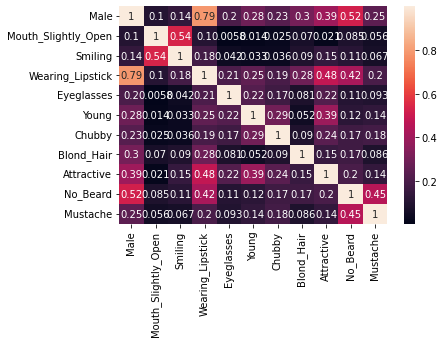

In [7]:
sb.heatmap(cramer_mat, annot=True, xticklabels=face_attr, yticklabels=face_attr)

<AxesSubplot:title={'center':"Theil's U"}>

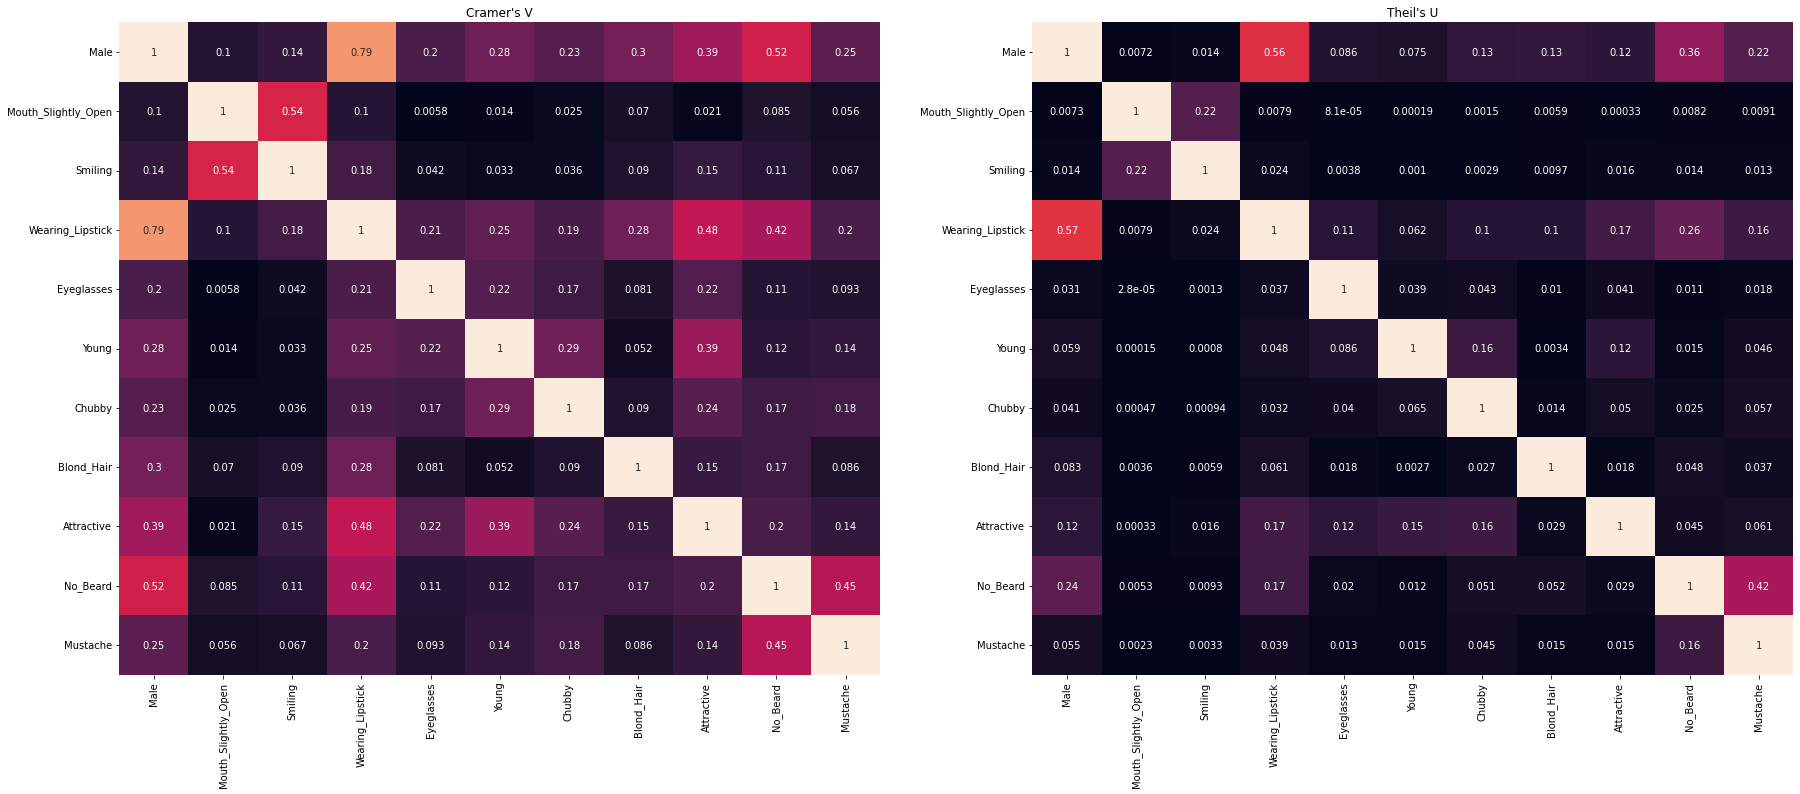

In [8]:
fig = plt.figure(figsize=(30, 12))
fig.add_subplot(1,2,1)
plt.title("Cramer's V")
sb.heatmap(cramer_mat, annot=True, xticklabels=face_attr, yticklabels=face_attr, cbar=False)

fig.add_subplot(1,2,2)
plt.title("Theil's U")
sb.heatmap(theils_mat, annot=True, xticklabels=face_attr, yticklabels=face_attr, cbar=False)

In [9]:
list(attributes.keys()).index("Mouth_Slightly_Open")
from argparse import Namespace
print(good_attributes)
print(list(attributes.keys()).index("Attractive"))

['image_id', 'Attractive', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Smiling', 'Wavy_Hair', 'Wearing_Lipstick']
3


In [10]:
args = Namespace(
    data_dir = './data/celeba',
)

In [11]:
from src.models.ours import OurGan
from src.models.autoencoder import AutoEncoder
from src.models.encodedclassifier import EncodedClassifier
from src.datamodule import CelebAEncodedDataset
import pytorch_lightning as pl
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# args = {k: v for k, v in args.items() if v is not None}
args = vars(args)
conf = yaml.load(open('config.yml'), Loader=yaml.FullLoader)
opt = conf['common']
opt.update(conf['translator'])
opt.update(args)
args = Namespace(**opt)

In [100]:
ATTRIBUTE_KEYS = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
args.target_attr = 'Smiling'
print(args)
autoencoder = AutoEncoder.load_from_checkpoint(hparams=args, checkpoint_path=os.path.join(args.pretrained_dir, args.pretrained_ver, args.pretrained_autoencoder))
decoder = autoencoder.decoder.eval()
classifier = EncodedClassifier.load_from_checkpoint(hparams=args, checkpoint_path=os.path.join(args.pretrained_dir, args.pretrained_ver, args.target_attr+".ckpt"))
classifiers = {}
for cls in args.classifiers.split(','):
    print(cls)
    idx = ATTRIBUTE_KEYS.index(cls)
    classifiers[idx] = EncodedClassifier.load_from_checkpoint(hparams=args, checkpoint_path=os.path.join(args.pretrained_dir, args.pretrained_ver, cls+".ckpt"))

ours = OurGan.load_from_checkpoint(hparams=args, decoder=decoder, classifier=classifier, classifiers=classifiers, checkpoint_path=os.path.join(args.pretrained_dir, 'done', 'smiling_500.ckpt'))
oursmale = OurGan.load_from_checkpoint(hparams=args, decoder=decoder, classifier=classifier, classifiers=classifiers, checkpoint_path=os.path.join(args.pretrained_dir, 'done', 'male_500.ckpt'))



Namespace(accumulate_grad_batches=1, b1=0.5, b2=0.999, batch_size=4, channels=3, classifiers='Male,Mouth_Slightly_Open,Smiling,Wearing_Lipstick,Eyeglasses,Young,Chubby,Blond_Hair,Attractive,No_Beard,Mustache', data_dir='./data/celeba', dataset='celeba', deterministic=True, encoded_dir='data_encoded', gpus=2, gradient_clip_val=0.5, id_gen='identity_generator.ckpt', images_dir='img_align_celeba_128', lambda_A=1, lambda_B=1, lambda_ce=1000, lambda_gan=1, lambda_idt=0.5, log_every_n_steps=1, lr_d=0.0002, lr_g=0.0002, max_epochs=100, num_workers=2, precision=16, pretrain=0, pretrained_autoencoder='autoencoder.ckpt', pretrained_dir='pretrained', pretrained_ver='v2', target_attr='Smiling', use_dropout=1, use_pretrain=0)
Male
Mouth_Slightly_Open
Smiling
Wearing_Lipstick
Eyeglasses
Young


/home/hjsong/anaconda3/envs/ppml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Chubby
Blond_Hair
Attractive
No_Beard
Mustache


In [101]:
dset = CelebAEncodedDataset(root=args.data_dir, train=1, encoded_dir=os.path.join(args.encoded_dir,args.pretrained_ver))
a2b = ours.A2B.eval()
b2a = ours.B2A.eval()
m2f = oursmale.A2B.eval()
f2m = oursmale.B2A.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


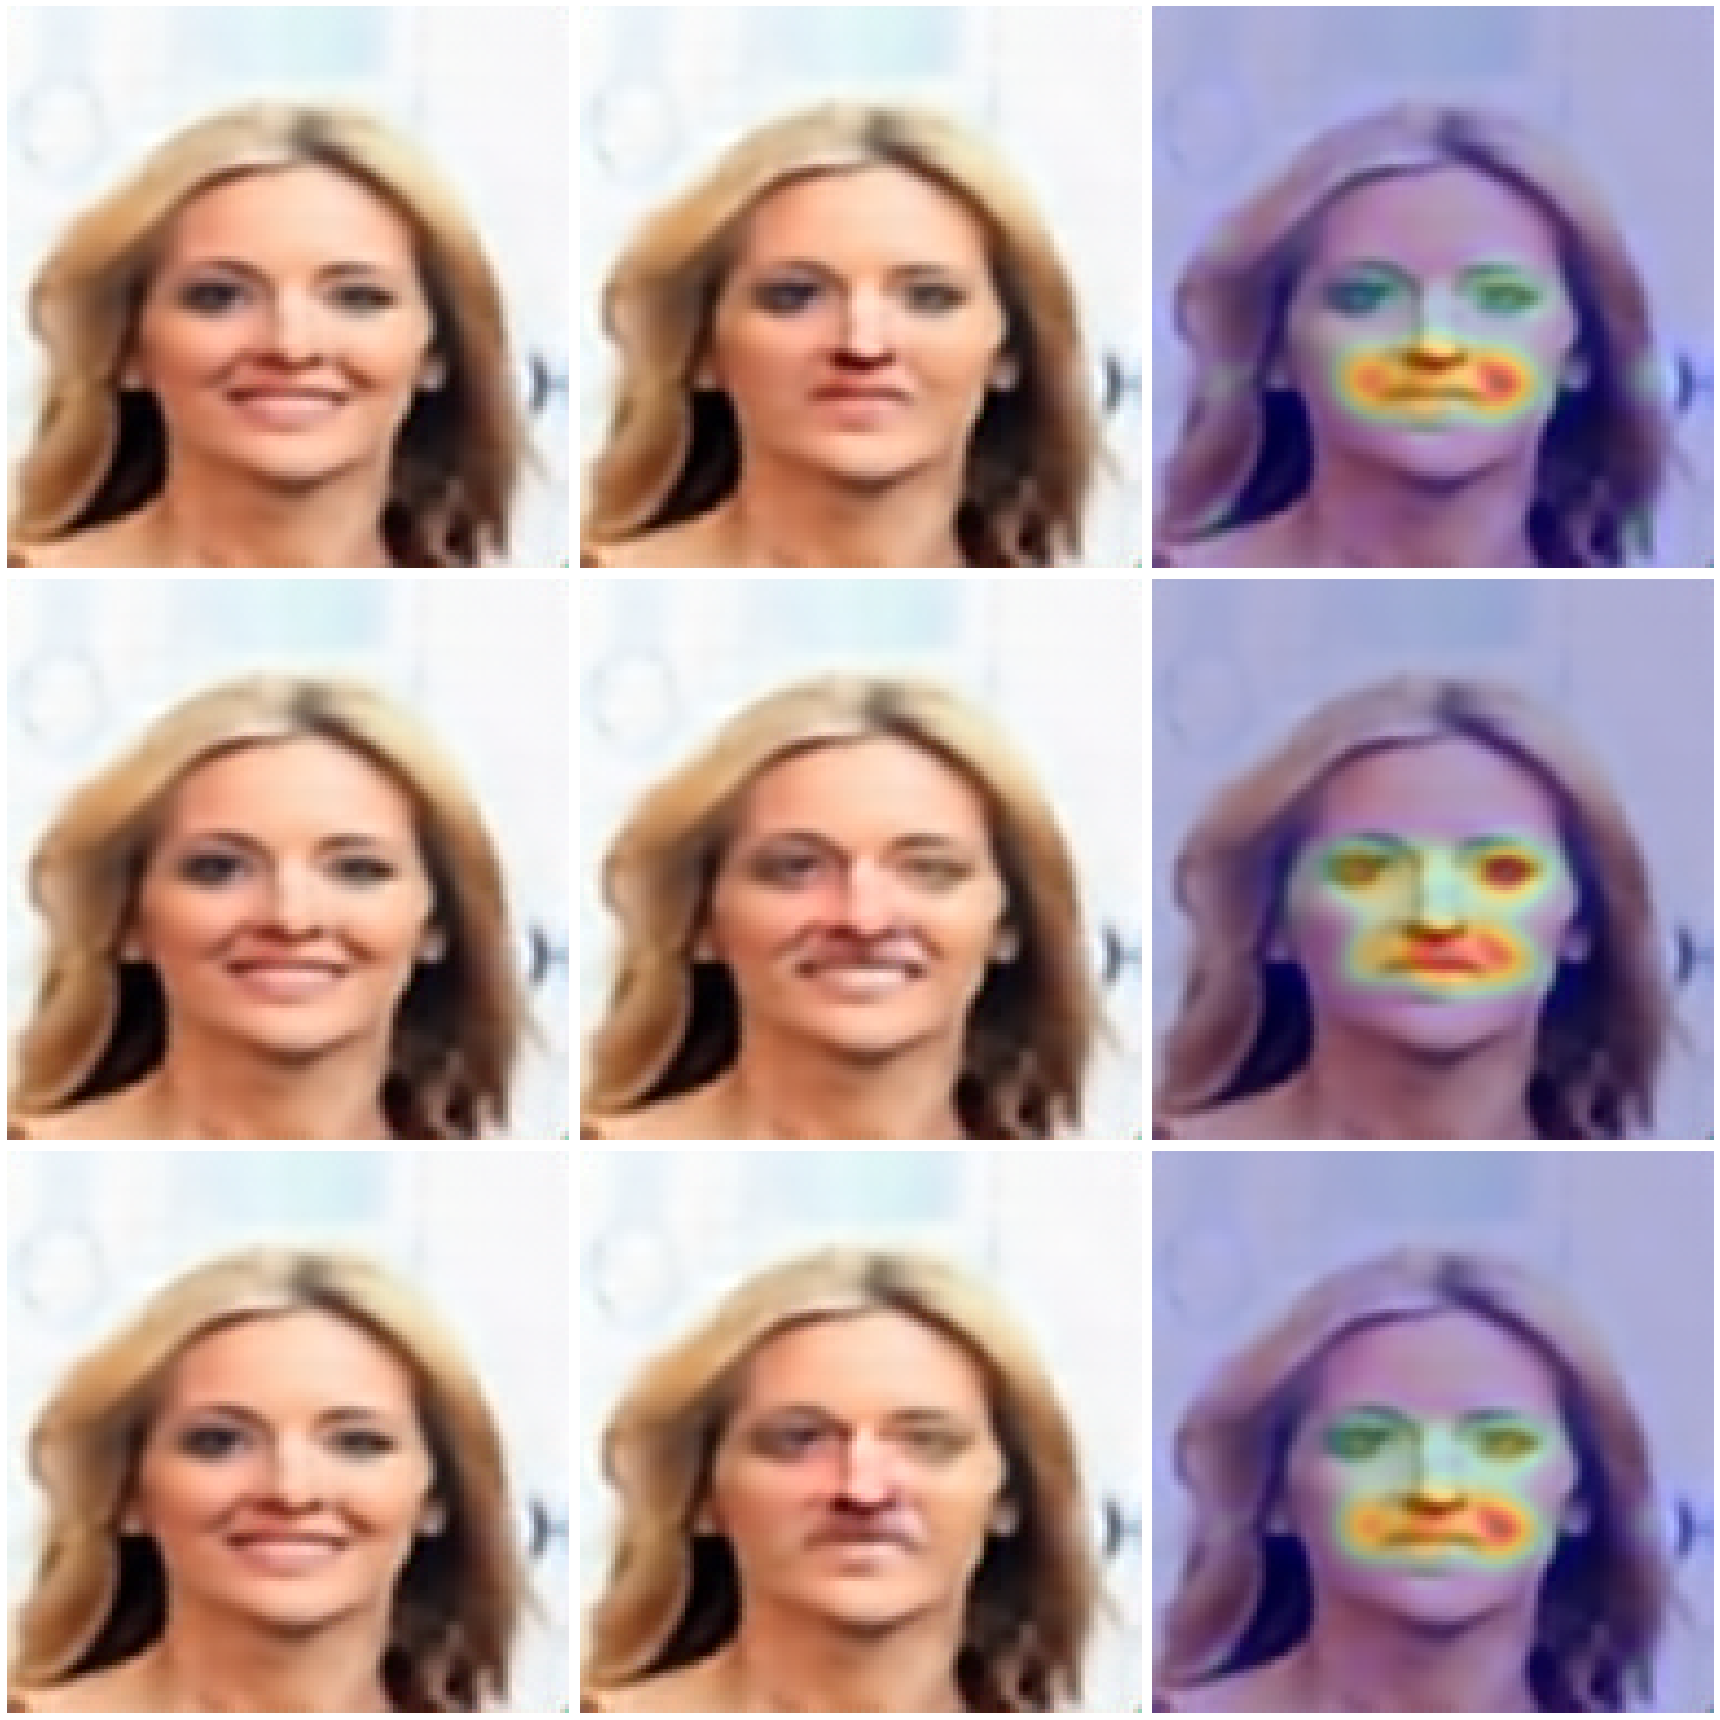

In [102]:
from torchvision.transforms import GaussianBlur
sample_idx = 19
img, attributes = dset[sample_idx]
sample = nn.Unflatten(1, (512, 4, 4))(img.unsqueeze(0))
sample_b = a2b(sample)
sample_m = f2m(sample)
sample_bm = a2b(f2m(sample))
sample_mb = f2m(a2b(sample))
s = decoder(sample)
b = decoder(sample_b)
m = decoder(sample_m)
bm = decoder(sample_bm)
mb = decoder(sample_mb)
d = torch.abs(b-s)
d = GaussianBlur((25, 25), 4)(torch.mean(d, dim=1, keepdim=True))
d = d/(torch.max(torch.max(d, dim=-1)[0], dim=-1)[0].unsqueeze(-1).unsqueeze(-1).expand(d.shape))
d2 = GaussianBlur((25, 25), 4)(torch.mean(torch.abs(m - s), dim=1, keepdim=True))
d2 = d2/(torch.max(torch.max(d2, dim=-1)[0], dim=-1)[0].unsqueeze(-1).unsqueeze(-1).expand(d2.shape))
d3 = GaussianBlur((25, 25), 4)(torch.mean(torch.abs(mb - s), dim=1, keepdim=True))
d3 = d3/(torch.max(torch.max(d3, dim=-1)[0], dim=-1)[0].unsqueeze(-1).unsqueeze(-1).expand(d2.shape))
d3 = GaussianBlur((25, 25), 4)(torch.mean(torch.abs(mb - s), dim=1, keepdim=True))
d3 = d3/(torch.max(torch.max(d3, dim=-1)[0], dim=-1)[0].unsqueeze(-1).unsqueeze(-1).expand(d2.shape))



fig = plt.figure(figsize=(24,24))
sf1 = fig.add_subplot(3,3,1)
plt.axis('off')
sf1.imshow(s[0].permute(1,2,0).data.numpy())
sf2 = fig.add_subplot(3,3,2)
plt.axis('off')
sf2.imshow(b[0].permute(1,2,0).data.numpy())
sf3 = fig.add_subplot(3,3,3)
plt.axis('off')
sf3.imshow(b[0].permute(1,2,0).data.numpy())
sf3.imshow(d[0].permute(1,2,0).data.numpy(), alpha=0.3, cmap=plt.cm.jet)
sf4 = fig.add_subplot(3,3,4)
plt.axis('off')
sf4.imshow(s[0].permute(1,2,0).data.numpy())
sf5 = fig.add_subplot(3,3,5)
plt.axis('off')
sf5.imshow(m[0].permute(1,2,0).data.numpy())
sf6 = fig.add_subplot(3,3,6)
plt.axis('off')
sf6.imshow(b[0].permute(1,2,0).data.numpy())
sf6.imshow(d2[0].permute(1,2,0).data.numpy(), alpha=0.3, cmap=plt.cm.jet)
plt.tight_layout()
sf4 = fig.add_subplot(3,3,7)
plt.axis('off')
sf4.imshow(s[0].permute(1,2,0).data.numpy())
sf5 = fig.add_subplot(3,3,8)
plt.axis('off')
sf5.imshow(bm[0].permute(1,2,0).data.numpy())
sf6 = fig.add_subplot(3,3,9)
plt.axis('off')
sf6.imshow(b[0].permute(1,2,0).data.numpy())
sf6.imshow(d3[0].permute(1,2,0).data.numpy(), alpha=0.3, cmap=plt.cm.jet)
plt.tight_layout()

In [ ]:
print([["female not smiling","female smiling"],["male not smiling", "male smiling"]][int((male+1)/2)][int((smiling+1)/2)])
smiling = attributes[ ATTRIBUTE_KEYS.index('Smiling')]
male = attributes[ ATTRIBUTE_KEYS.index('Male')]
if smiling==1:
    if male==1:
        ms = decoder(sample)
        mn = decoder(a2b(sample))
        fs = decoder(m2f(sample))
        fn = decoder(m2f(a2b(sample)))
    else:
        fs = decoder(sample)
        fn = decoder(a2b(sample))
        ms = decoder(f2m(sample))
        mn = decoder(f2m(a2b(sample)))
else:
    if male==1:
        ms = decoder(b2a(sample))
        mn = decoder(sample)
        fs = decoder(m2f(b2a(sample)))
        fn = decoder(m2f(sample))
        fig = plt.figure(figsize=(8, 8))
        with torch.no_grad():
            fig.add_subplot(2,2,1)
            plt.axis('off')
            plt.imshow(mn[0].permute(1,2,0).data.numpy())
            fig.add_subplot(2,2,2)
            plt.axis('off')
            plt.imshow(ms[0].permute(1,2,0).data.numpy())
            fig.add_subplot(2,2,3)
            plt.axis('off')
            plt.imshow(fn[0].permute(1,2,0).data.numpy())
            fig.add_subplot(2,2,4)
            plt.axis('off')
            plt.imshow(fs[0].permute(1,2,0).data.numpy())
            plt.tight_layout()
    else:
        fs = decoder(b2a(sample))
        fn = decoder(sample)
        ms = decoder(f2m(b2a(sample)))
        mn = decoder(f2m(sample))

In [ ]:
train = pd.read_csv('data/CheXpert-v1.0-small/valid.csv')

In [ ]:
import os
from PIL import Image
old_dir = "data"
new_dir = "data_preprocessed"

for path in train["Path"]:
    old_path = os.path.join(old_dir, path)
    new_path = os.path.join(new_dir, path)
    directory = os.path.join(*new_path.split("/")[:-1])
    if not os.path.exists(directory):
        os.makedirs(directory)
    img = Image.open(old_path)
    processed = img.resize((128, 128))
    processed.save(new_path)

In [ ]:
args = Namespace(
    data_dir = './data_preprocessed/CheXpert-v1.0-small',
    pretrained_ver = 'ch',
    dataset = 'chexpert'
)
from src.models.ours import OurGan
from src.models.autoencoder import AutoEncoder
from src.models.encodedclassifier import EncodedClassifier
from src.datamodule import CelebAEncodedDataset
import pytorch_lightning as pl
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

args = vars(args)
conf = yaml.load(open('config.yml'), Loader=yaml.FullLoader)
opt = conf['common']
opt.update(conf['autoencoder'])
opt.update(args)
args = Namespace(**opt)



attributes_csv='train.csv'
attributes = pd.read_csv(os.path.join(args.data_dir, attributes_csv))
images_dir = os.path.join(args.data_dir)
encoded_dir = os.path.join(args.encoded_dir, args.pretrained_ver)


